In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from time import time 

# The Fokker-Planck equation

We have been looking at SDEs written on the form 

$$ \mathrm{d} X = a(X, t) \, \mathrm{d}t + b(X, t) \, \mathrm{d}W, $$

where $a(X, t)  \, \mathrm{d}t $ is called the drift coefficient, and $b(X, t) \, \mathrm{d}W $ is called the diffusion term, or noise term.

Provided that $a(X, t)$ and $b(X, t)$ are "moderately smooth functions" (Kloeden & Platen, p. 37), there also exists a Partial Differential Equation (PDE) that describes how the distribution of solutions to the SDE will develop. This is called the Fokker-Planck equation, or the forward Kolmogorov equation.

Assume that we have an ensemble of particles, starting out at $(x_0, t_0)$, and their motion is described by the SDE above. Then the probability distribution, $p(x, t | x_0, t_0)$, or just $p(x, t)$ for convenience, will develop according to

$$ \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \big( a(x, t) \, p(x, t) \big) + \frac{1}{2} \frac{\partial^2}{\partial x^2} \big( b^2(x, t) \, p(x, t) \big). $$



**Note on notation:** I try to be consistent in using $X$ for a stochastic process, and $x$ when $x$ is just a regular, independent variable.

## Example: Constant coefficients, the advection-diffusion equation

As a simple example, consider the SDE with constant coefficients:

$$ \mathrm{d} x = v \, \mathrm{d}t + \sqrt{2K} \, \mathrm{d}W, $$

i.e, $a(X, t) = \alpha$ and $b(X, t) = \beta$. In this case, the Fokker-Planck equation becomes

$$ \frac{\partial p(x,t)}{\partial t} = -v \frac{\partial }{\partial x} p(x, t) + K \frac{\partial^2 }{\partial x^2} p(x, t). $$

We recognise this as the advection-diffusion equation for constant advection, $v$, and  diffusivity $K$. The solution to this equation, for a set of particles all initially located at $x_0$ at time $t=t_0$, i.e., for $p(x, t_0)=\delta(x-x_0)$, is a Gaussian with mean $\mu(t) = x_0 + v(t-t_0)$ and variance $\sigma^2(t) = 2Kt$:

$$ p(x, t) = \frac{1}{2\pi \sigma} \exp\left( \frac{1}{2} \frac{(x-\mu)^2}{\sigma^2} \right). $$

The advection-diffusion equation will be an important topic, which we will get back to both later today and in the other lectures.

In [2]:
# An SDE solver

def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dt
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW

def solve_SDE(X0, tmax, dt, a, b, solver, W=None):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    for n in range(1, Nt):
        # Call solver, with pre-computed W if available
        if W is None:
            X[n,:] = solver(X[n-1,:], t, dt, a, b)
        else:
            # Obtain increment from pre-computed Wt
            dW = W[n] - W[n-1]
            X[n,:] = solver(X[n-1,:], t, dt, a, b, dW=dW)
        t += dt
    return X

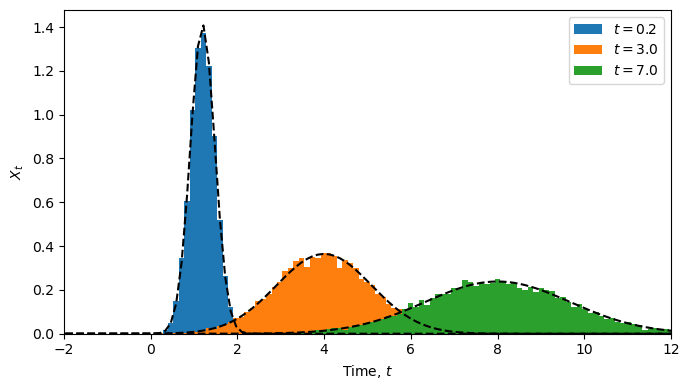

In [3]:
v = 1
K = 0.2

# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    return v

def b(X, t):
    return np.sqrt(2*K)

# Several initial values leads to several solutions
Np = 10000
X0 = 1.0
# Integration time
tmax = 10
# timestep
dt = 0.1

X = solve_SDE(X0*np.ones(Np), tmax, dt, a, b, EM)

t = dt*np.arange(len(X))
bins=np.linspace(-5, 20, 200)
mids=bins[:-1] + (bins[1]-bins[0])/2

# Plot the solution
fig = plt.figure(figsize = (7, 4))

for i in [2, 30, 70]:
    plt.hist(X[i,:], bins=bins, density=True, label=f'$t={t[i]}$')
    mu = X0 + v*t[i]
    sigma = np.sqrt(2*K*t[i])
    plt.plot(mids, np.exp(-0.5*(mids-mu)**2/sigma**2) / (np.sqrt(2*np.pi)*sigma), '--', c='k')
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(-2, 12)
plt.legend()
plt.tight_layout()

## Example: Geometric Brownian motion

We recall that geometric Brownian motion was described by the SDE

$$ \mathrm{d} X = \alpha X \, \mathrm{d}t + \beta X \, \mathrm{d}W, $$

i.e, $a(X, t) = \alpha X$ and $b(X, t) = \beta X$. In this case, the Fokker-Planck equation becomes

$$ \frac{\partial p(x,t)}{\partial t} = - \alpha  \frac{\partial }{\partial x} (x p) + \frac{\beta^2 }{2}\frac{\partial^2 }{\partial x^2} (x^2 p). $$

This is a non-linear PDE, which we could solve numerically, but it does in fact also have an analytical solution (see for example the Wikipedia page on Geometric Brownian motion), if the initial condition is a delta function, $p(x, t_0) = \delta(x-x_0)$:

$$ p(x, t) = \frac{1}{\sqrt{2\pi t}\, \beta x} \, \exp\left(- \frac{1}{2} \frac{\big(\log x - \log x_0 - (a - \beta^2/2) t\big)^2}{\beta^2 t} \right). $$

This is called the log-normal distribution, and has the property that if $x$ is log-normally distributed, then $\log x$ is normally distributed.

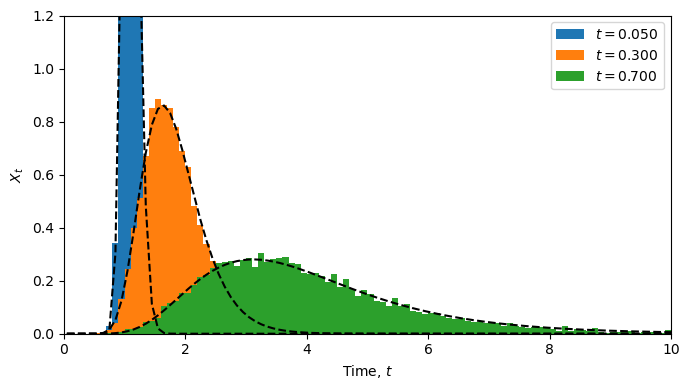

In [4]:
alpha = 2
beta  = 0.5

# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    return alpha*X

def b(X, t):
    return beta*X

# Several initial values leads to several solutions
Np = 10000
X0 = 1.0
# Integration time
tmax = 1
# timestep
dt = 0.01

X = solve_SDE(X0*np.ones(Np), tmax, dt, a, b, EM)

t = dt*np.arange(len(X))
bins=np.linspace(0, 20, 201)
mids=bins[:-1] + (bins[1]-bins[0])/2

# Plot the solution
fig = plt.figure(figsize = (7, 4))

for i in [5, 30, 70]:
    plt.hist(X[i,:], bins=bins, density=True, label=f'$t={t[i]:.3f}$')
    mu = (alpha - 0.5*beta**2)
    plt.plot(mids, np.exp(-(np.log(mids)-np.log(X0)-mu*t[i])**2/(2*t[i]*beta**2)) / (np.sqrt(2*np.pi*t[i])*beta*mids), '--', c='k')
    
    
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(0, 10)
plt.ylim(0, 1.2)
plt.legend()
plt.tight_layout()

## Numerical solution of the Fokker-Planck equation for Geometric Brownian motion

We can also solve the PDE numerically, which is often what we will do.

A simple approach in this case is the so-called FTCS method (Forward time, central space), which means that we discretise the time-derivative by the Forward Euler method, and the spacial derivatives by central finite difference.

See for example

https://github.com/nordam/ComputationalPhysics/blob/master/Notebooks/12%20-%20Partial%20Differential%20Equations.ipynb

In [5]:
def FTCS_geometric(x, p0, alpha, beta, dt, tmax):
    # A very hasty implementation that ignores the boundaries
    p = p0.copy()
    Nt = int(tmax/dt)
    dx = x[1]-x[0]
    for i in range(Nt):
        p[1:-1] = p[1:-1] + dt*(
            (beta**2-alpha)*p[1:-1]
            +x[1:-1]*(2*beta**2 - alpha)*(p[2:] - p[:-2])/(2*dx)
            +(beta**2 * x[1:-1]**2 / 2)*(p[2:] -2*p[1:-1] + p[:-2])/(dx**2)
        )
    return p

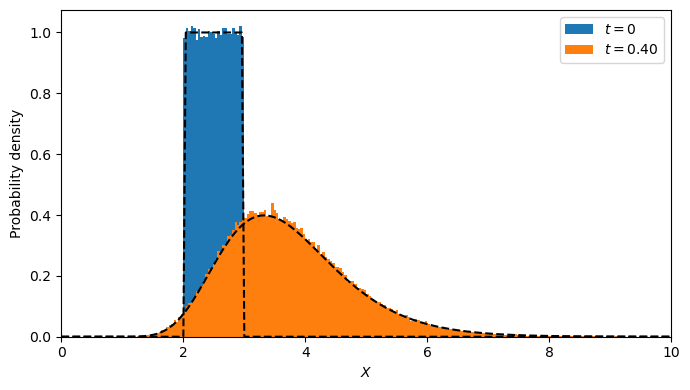

In [6]:
alpha = 1
beta  = 0.4

# Implementing a and b as functions of X and t
# for consistency with the general solver
def a(X, t):
    return alpha*X

def b(X, t):
    return beta*X

# Initial condition, uniform distribution between low and high
low  = 2
high = 3

Np = 100000 # Number of particles
dt = 0.01   # Timestep
tmax = 0.4  # Integration time

X0 = np.random.uniform(low=low, high=high, size=Np)
X = solve_SDE(X0, tmax, dt, a, b, EM)

# Grid points and initial conditions for PDE
x, dx = np.linspace(0, 20, 501, retstep=True)
p0 = np.where((low<x)&(x<high), 1., 0.)


fig = plt.figure(figsize = (7, 4))

# Plot histogram of particle positions
plt.hist(X[0,:], bins=x, density=True, label='$t=0$')
plt.hist(X[-1,:], bins=x, density=True, label=f'$t={tmax:.2f}$')

# Plot numerical solution of PDE
plt.plot(x, p0, '--', c='k')
plt.plot(x, FTCS_geometric(x, p0, alpha, beta, 0.00001, tmax), '--', c='k')

plt.xlabel('$X$')
plt.ylabel('Probability density')
plt.xlim(0, 10)
plt.legend()
plt.tight_layout()

## Example: Diffusion-equation with non-constant diffusivity

For non-constant coefficients, the advection-diffusion equation with advection $v(x)$ and diffusion $K(x)$ is 

$$ \frac{\partial}{\partial t} \, p(x,t) = - \frac{\partial }{\partial x} \Big( p(x, t) \, v(x) \Big) + \frac{\partial }{\partial x} \left( K(x) \frac{\partial }{\partial x} p(x, t)\right), $$

or more compactly

$$ \frac{\partial p}{\partial t}  = - \frac{\partial }{\partial x} (pv) + \frac{\partial }{\partial x} \left( K \frac{\partial p}{\partial x}\right). $$

What is the corresponding SDE?

We rewrite the Fokker-Planck equation a little (using the product rule once, and drop the arguments to $p$, $a$ and $b$ for brevity):

$$ \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \left[ \left( a - \frac{1}{2}\frac{\partial b^2}{\partial x} \right) p \right] + \frac{\partial}{\partial x} \left( \frac{b^2}{2} \frac{\partial p}{\partial x} \right). $$

Compare the terms in this form of the Fokker-Planck equation directly to the advection-diffusion equation, and we find

\begin{align}
K &= \frac{b^2}{2} \;\; \Rightarrow \;\;  b = \sqrt{2K}, \\
v &= a - \frac{1}{2}\frac{\partial b^2}{\partial x} \;\; \Rightarrow \;\;  a = v + \frac{\partial K}{\partial x}.
\end{align}

Hence, the SDE that corresponds to the advection-diffusion equation with non-constant coefficients is:

$$ \mathrm{d} x = \left(v +  \frac{\partial K}{\partial x} \right) \, \mathrm{d}t + \sqrt{2K} \, \mathrm{d}W. $$


## Example: The Ornstein-Uhlenbeck process

The solution of the SDE

$$ dX = -\alpha X \, \mathrm{d}t + \beta  \, \mathrm{d} W_t, $$

where $\alpha > 0$, $\beta > 0$ is called the Ornstein-Uhlenbeck process. In this case, the Fokker-Planck equation becomes

$$ \frac{\partial p(x,t)}{\partial t} = \alpha \frac{\partial }{\partial x} (x p) + \frac{\beta^2}{2}\frac{\partial^2 p}{\partial x^2}. $$

This equation also has an analytical solution for the initial condition $p(x, t=0) = \delta(x-x_0)$ (see for example the Wikipedia page for the Ornstein-Uhlenbeck process). The solution is a Gaussian distribution with mean

$$ \mu = x_0 \mathrm{e}^{-\alpha t}$$
and variance 
$$\sigma^2 = \frac{\sigma^2}{2\alpha}\big(1 - \mathrm{e}^{-2\alpha t}\big).$$


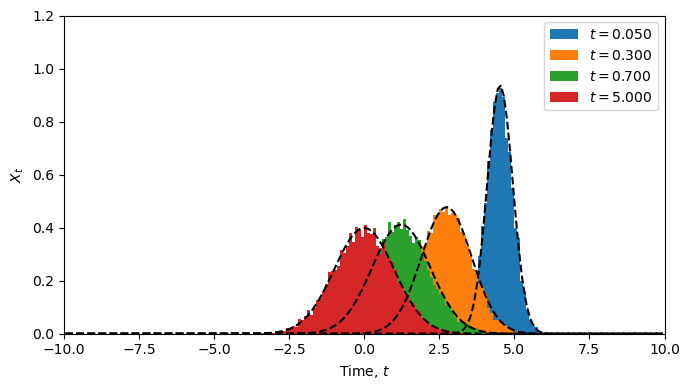

In [7]:
alpha = 2
beta  = 2

# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    return -alpha*X

def b(X, t):
    return beta

# Several initial values leads to several solutions
Np = 10000
X0 = 5.0
# Integration time
tmax = 5
# timestep
dt = 0.01

X = solve_SDE(X0*np.ones(Np), tmax, dt, a, b, EM)

t = dt*np.arange(len(X))
bins=np.linspace(-10, 10, 201)
mids=bins[:-1] + (bins[1]-bins[0])/2

# Plot the solution
fig = plt.figure(figsize = (7, 4))

for i in [5, 30, 70, -1]:
    plt.hist(X[i,:], bins=bins, density=True, label=f'$t={t[i]:.3f}$')
    mu = X0*np.exp(-alpha*t[i])
    sigma2 = (beta**2 / (2*alpha)) * (1 - np.exp(-2*alpha*t[i]))
    plt.plot(mids, np.exp(-(mids - mu)**2/(2*sigma2)) / (np.sqrt(2*np.pi*sigma2)), '--', c='k')
    
    
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(-10, 10)
plt.ylim(0, 1.2)
plt.legend()
plt.tight_layout()

# References

Kloeden & Platen (1992), _Numerical Solution of Stochastic Differential Equations_. https://link.springer.com/book/10.1007/978-3-662-12616-5